# Data preprocessing for $t\bar{t}$ jet tagging

In this program, we will use a combination of event variables and jet hit maps to train a machine learning algorithm to identify $t\bar{t}$ jets from QCD jet backgrounds. To optimize performance, we explore correlations between variables to inform choices for data preprocessing.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

We have two forms of input data: images and event features.

Images show hits of the jets on the detector, providing us 2D information on the energy and position of particles from the jets.

We can aggregate data from the hits and reduce this information to a small set of event features: $N_c$, $p_{T}$, $\phi$, and $\eta$. These features describe the number of clusters in the event, the transverse momentum, and two angles describing the jets direction off the beam axis. To avoid overtraining, we assess the correlations between these variables and use that information to conclude how to preprocess the data.

In [2]:
train_path = "../../train/"
val_path = "../../val/"
test_path = "../../test/"

def load_data_files(path):
    ji = os.path.join(path, "images/jet_images.h5")
    ids = os.path.join(path, "ids/ids.npy")
    features = os.path.join(path, "features/cluster_features.csv")
    labels = os.path.join(path, "labels/labels.npy")
    return ji, ids, features, labels

train_ji, train_ids, train_feat, train_labels = load_data_files(train_path)
val_ji, val_ids, val_feat, val_labels = load_data_files(val_path)
test_ji, test_ids, test_feat, test_labels = load_data_files(test_path)

In [3]:
train_df = pd.read_csv(train_feat)
val_df = pd.read_csv(val_feat)
test_df = pd.read_csv(test_feat)
train_df

,n_clusters,max_cluster_pt,mean_cluster_pt,std_cluster_pt,max_cluster_size,mean_cluster_size,std_cluster_size,total_pt,max_cluster_eta,max_cluster_phi,mean_cluster_eta,mean_cluster_phi,cluster_pt_ratio,cluster_size_ratio
0,13,2.0,0.615318,0.539951,2,2.0,0.0,7.999129,0.5,0.7,0.076923,0.346154,1.470200,1.0
1,10,2.0,0.777020,0.601157,2,2.0,0.0,7.770204,0.2,0.5,0.100000,0.230000,1.430785,1.0
2,4,2.0,0.972718,0.606990,2,2.0,0.0,3.890871,0.1,0.1,0.050000,0.050000,2.557882,1.0
3,14,2.0,0.746367,0.485636,2,2.0,0.0,10.449135,0.5,0.5,0.185714,0.285714,1.624096,1.0
4,6,2.0,0.575760,0.639069,2,2.0,0.0,3.454561,0.1,0.1,0.050000,0.066667,4.988196,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3515,11,2.0,0.721241,0.580598,2,2.0,0.0,7.933646,0.2,0.9,0.063636,0.481818,1.202968,1.0
3516,2,2.0,1.159625,0.840375,2,2.0,0.0,2.319249,0.1,0.1,0.050000,0.050000,6.264701,1.0
3517,5,2.0,0.804492,0.635988,2,2.0,0.0,4.022461,0.1,0.1,0.060000,0.040000,2.295435,1.0
3518,6,2.0,0.766277,0.713626,2,2.0,0.0,4.597664,0.1,0.5,0.050000,0.350000,1.327499,1.0


We see that many of these features contain no information, so we discard them and focus on a reduced dataset.

In [4]:
def reduce_dataframe(df):
    reduced_df = df[["n_clusters", "mean_cluster_pt", "std_cluster_pt", "total_pt",
                    "max_cluster_eta", "max_cluster_phi", "mean_cluster_eta",
                    "mean_cluster_phi", "cluster_pt_ratio"]]
    return reduced_df
    
train_red_df = reduce_dataframe(train_df)
val_red_df = reduce_dataframe(val_df)
test_red_df = reduce_dataframe(test_df)

We now compute the correlation matrix using the Pearson coefficient.

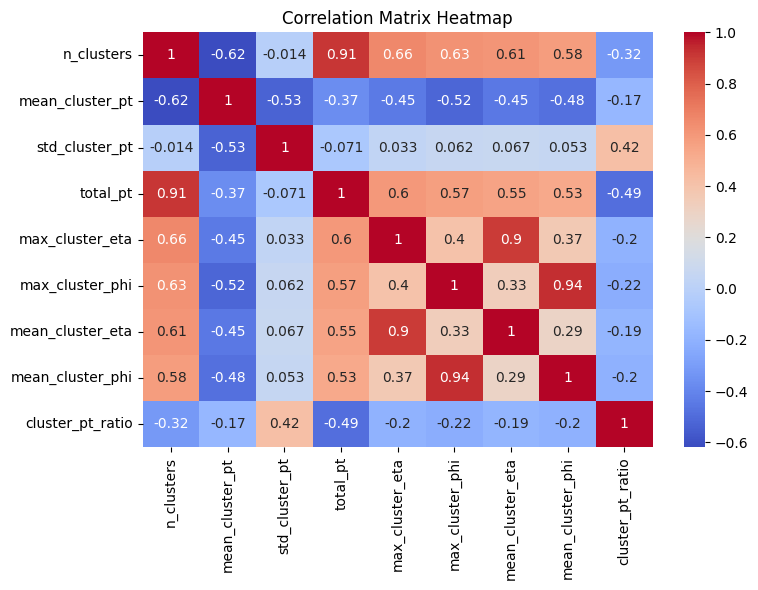

In [5]:
# compute correlation matrix
corr_matrix = train_red_df.corr()

# plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,            # show correlation values
    cmap='coolwarm',       # color palette
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

As we can see, there is high correlation between many of our features. If we were to pass the data as is, we would run the risk of overtraining. To avoid this, we will explore different avenues of reducing our dataset.

# Avenue 1: Feature selection with BDT
We can use BDTs to grab feature importance. This will allow us to select the most important features! Ideally, the BDT will pick features with low correlation in the correlation matrix, which we can then use to select a subset of our feature space.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

# load our data
X_train = train_red_df.to_numpy()
y_train = np.load(train_labels)
X_val = val_red_df.to_numpy()
y_val = np.load(val_labels)
X_test = test_red_df.to_numpy()

# preprocess with standard scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
data_labels = train_red_df.columns.to_numpy()

def train_bdt(X_train, y_train, X_val, y_val, labels):
    # train BDT
    clf = GradientBoostingClassifier(
        n_estimators = 100, max_depth = 3, learning_rate = 0.1
    )
    clf.fit(X_train, y_train)

    # Compute score on val data
    print("Score on validation data:", clf.score(X_val, y_val))

    # Examine feature importance
    sortidx = np.flip(np.argsort(clf.feature_importances_))
    sorted_featimp = clf.feature_importances_[sortidx]
    sorted_labels = labels[sortidx]

    print("Feature,     Importance")
    for i in range(len(labels)):
        print(sorted_labels[i], sorted_featimp[i])

    return clf

clf = train_bdt(X_train_scaled, y_train, X_val_scaled, y_val, data_labels)

Score on validation data: 0.8804780876494024
Feature,     Importance
mean_cluster_phi 0.5643106916021834
max_cluster_phi 0.30718524495086214
mean_cluster_pt 0.02787562676688784
n_clusters 0.022441040961445377
mean_cluster_eta 0.022439725977016142
cluster_pt_ratio 0.022373549257552704
total_pt 0.014022916539103232
std_cluster_pt 0.013371673273323758
max_cluster_eta 0.005979530671625435


We see that $\langle \phi_c \rangle$ and $max(\phi_c)$ contribute the most to distinguishing signal from backgrounds, but these features are highly correlated! Can we reduce our dataset to something with less correlations?

# Time to try PCA!

PCA stands for Principle Component Analysis, and selects the vectors of greatest variance, called principle components, in the dataset. By transforming our dataset into the basis of principle components, we can reduce the correlation of features in our dataset and hopefully reduce the number of overall features!

We can choose to keep all principle components in our data, or we can choose to keep only certain components. We will demonstrate both here and observe their performance when training a BDT.

To reduce the dimensionality of our data, we use Minka's Maximum Likelihood Estimate (MLE), described here:
https://vismod.media.mit.edu/tech-reports/TR-514.pdf

As we will see, applying this metric to our data only reduces the dimensionality of our dataset by one.

In [7]:
from sklearn.decomposition import PCA
all_pca = PCA(whiten = True)                       # no component selection
mle_pca = PCA(n_components = "mle", whiten = True) # component selection using Minka's MLE

all_pca.fit(X_train)
mle_pca.fit(X_train)

X_train_all_pca = all_pca.transform(X_train)
X_val_all_pca = all_pca.transform(X_val)
X_train_mle_pca = mle_pca.transform(X_train)
X_val_mle_pca = mle_pca.transform(X_val)

print(X_train_all_pca.shape)
print(X_train_mle_pca.shape)

(3520, 9)
(3520, 8)


In [8]:
# Now assess performance on BDTs

print("Running PCA with all components")
all_clf = train_bdt(X_train_all_pca, y_train, X_val_all_pca, y_val,
                    np.array(range(X_train_all_pca.shape[1])))

print("\nRunning PCA using Minka's MLE")
mle_clf = train_bdt(X_train_mle_pca, y_train, X_val_mle_pca, y_val,
                    np.array(range(X_train_mle_pca.shape[1])))

Running PCA with all components
Score on validation data: 0.8745019920318725
Feature,     Importance
3 0.6733939829362019
0 0.12197202604996951
4 0.07199069795591893
7 0.06235021923333421
5 0.028677932334786736
2 0.01215318839123713
1 0.012012666298745542
6 0.009792431931229511
8 0.007656854868576539

Running PCA using Minka's MLE
Score on validation data: 0.8725099601593626
Feature,     Importance
3 0.6766170879215895
0 0.12169797873290383
4 0.07001546847371898
7 0.06390975880714651
5 0.03014359015641717
1 0.012705375206392222
2 0.012516323189629367
6 0.012394417512202535


In [9]:
# save this data to a csv!

X_test_all_pca = all_pca.transform(X_test)
for i in range(X_train_all_pca.shape[1]):
    train_pca_i = pd.DataFrame({f"PCA_{i}": X_train_all_pca[i]})
    val_pca_i = pd.DataFrame({f"PCA_{i}": X_val_all_pca[i]})
    test_pca_i = pd.DataFrame({f"PCA_{i}": X_test_all_pca[i]})
    train_df.join(train_pca_i)
    val_df.join(val_pca_i)
    test_df.join(test_pca_i)

train_df.to_csv(os.path.join(train_path, "features/train_pca_features.csv"))
val_df.to_csv(os.path.join(test_path, "features/val_pca_features.csv"))
test_df.to_csv(os.path.join(test_path, "features/test_pca_features.csv"))